In [3]:
import sys
sys.path.append("../")
sys.path.append("../../../assets")

# Get rid of annoying tf warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import bayesflow as beef
import pandas as pd

from experiments import RandomWalkDiffusionExperiment
from diffusion.models import RandomWalkDiffusion
from configuration import default_num_steps

/Users/lukas/opt/miniconda3/envs/bfPower/lib/python3.10/site-packages/bayesflow/trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [60]:
# If set to False, existing results will be loaded
# Set to True if you want to re-run the experiments
TRAIN_NETWORKS = False
FIT_MODEL = False

NUM_SAMPLES = 2000

PARAM_LABELS = ['Drift rate', 'Threshold', 'Non-decision time']
PARAM_NAMES  = [r'$v$', r'$a$', r'$\tau$']
FONT_SIZE_1 = 20
FONT_SIZE_2 = 18
FONT_SIZE_3 = 16

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "sans-serif"

## Neural Experiment

In [5]:
model = RandomWalkDiffusion(num_steps=default_num_steps)
neural_experiment = RandomWalkDiffusionExperiment(model)

INFO:root:Performing 2 pilot runs with the random_walk_diffusion_model model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 1320, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1320)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 1320, 3)
INFO:root:No shared_prior_draws provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.
INFO:root:Loaded loss history from ../checkpoints/optimal_policy/history_75.pkl.
INFO:root:Networks loaded from ../checkpoints/optimal_policy/ckpt-75
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


### Training

In [6]:
if TRAIN_NETWORKS:
    history = neural_experiment.run(
        epochs=75, 
        iterations_per_epoch=1000, 
        batch_size=16
    )
else:
    history = neural_experiment.trainer.loss_history.get_plottable()

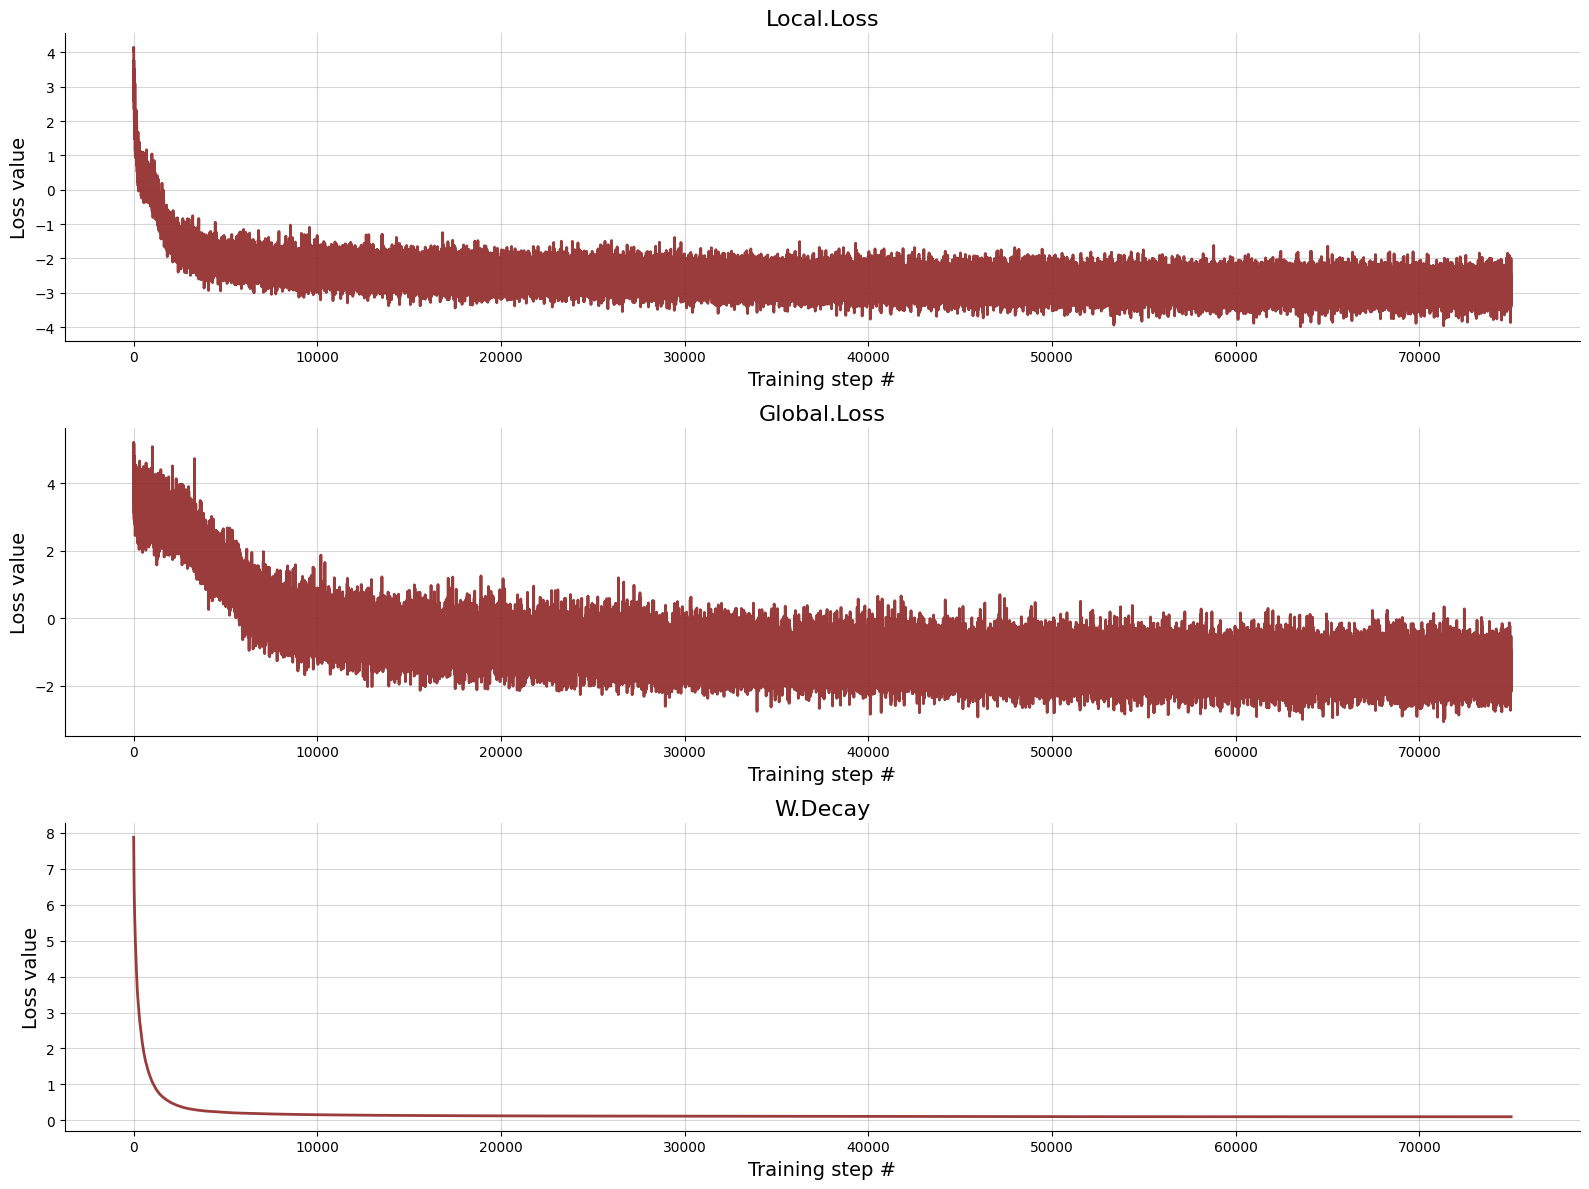

In [7]:
f = beef.diagnostics.plot_losses(history)

## Evaluation

### Prior predictive checks

In [8]:
sim_data = model.generate(1)
true_params = sim_data['local_prior_draws'][0]

In [7]:
with tf.device('/cpu:0'):
    post_samples = neural_experiment.amortizer.sample(model.configure(sim_data), NUM_SAMPLES)

In [8]:
post_samples['local_samples'].shape
theta_t = post_samples['local_samples'] * model.local_prior_stds + model.local_prior_means
theta_t_means = theta_t.mean(axis=1)
theta_t_stds = theta_t.std(axis=1)

<bound method Figure.tight_layout of <Figure size 2000x1000 with 3 Axes>>

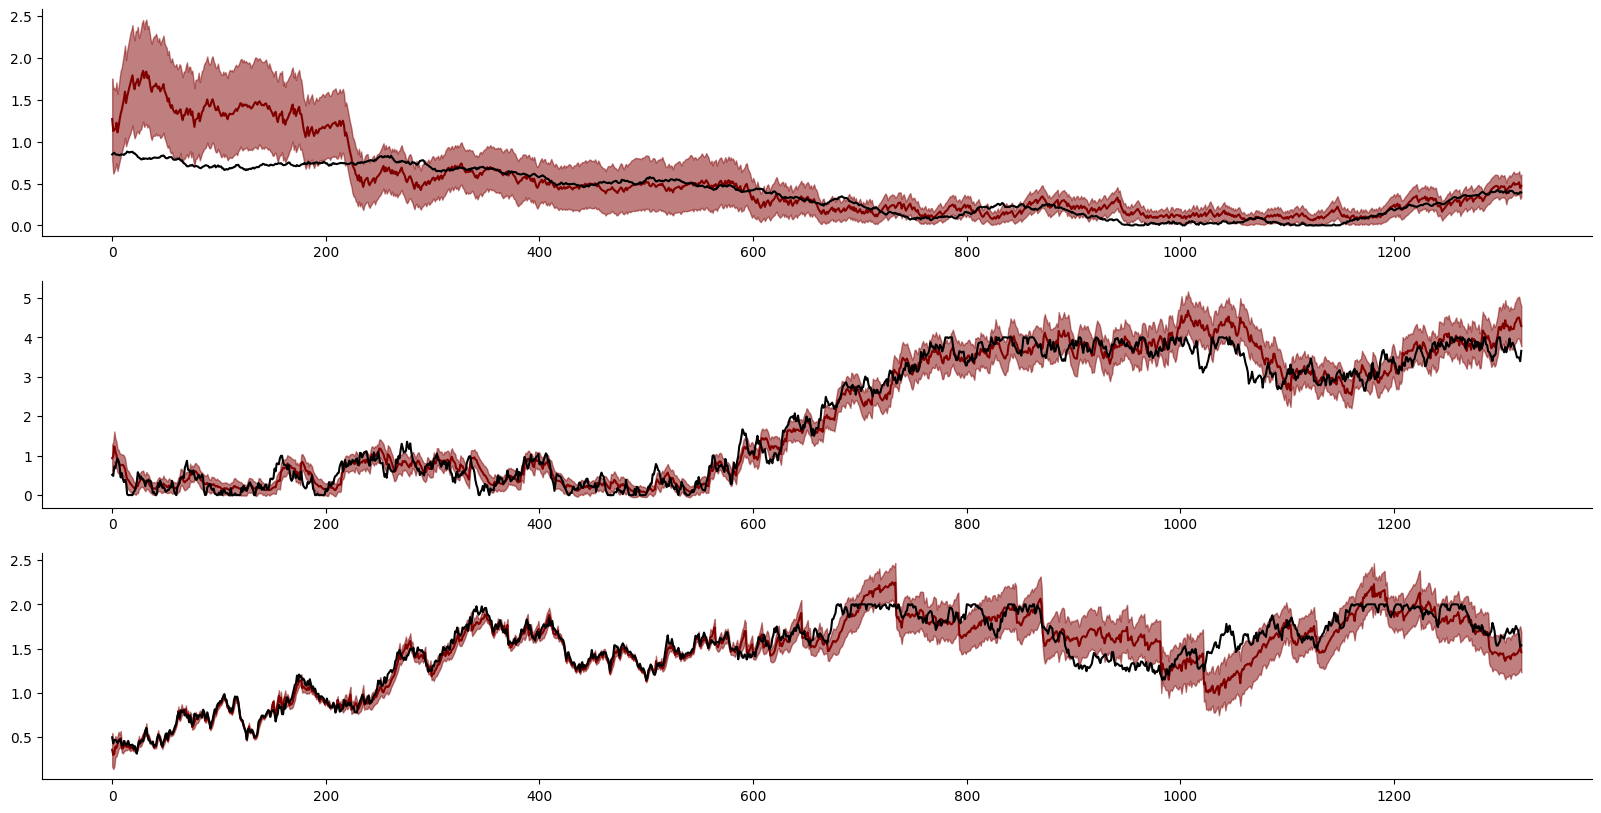

In [9]:
time = np.arange(theta_t_means.shape[0])
f, axarr = plt.subplots(3, 1, figsize=(20, 10))
for i, ax in enumerate(axarr.flat):
    ax.plot(time, theta_t_means[:, i], color='maroon', label='Posterior mean')
    ax.fill_between(
        time,
        theta_t_means[:, i] - theta_t_stds[:, i],
        theta_t_means[:, i] + theta_t_stds[:, i],
        color='maroon',
        alpha=0.5
        )
    ax.plot(time, true_params[:, i], color='black', label='True parameter')
sns.despine()
f.tight_layout


### Fit to empiric data

In [71]:
# prepare data
data = pd.read_csv('../data/optimal_policy_data.csv')
NUM_SUBS = len(np.unique(data['id']))

In [10]:
if FIT_MODEL:
    posterior_samples = np.full((NUM_SUBS, default_num_steps, NUM_SAMPLES, 3), np.nan)
    for i in range(NUM_SUBS):
        person_data = {"summary_conditions": data['rt'].loc[data['id'] == i + 1].to_numpy()[None, ..., None]}
        posterior_samples_z = neural_experiment.amortizer.sample(person_data, NUM_SAMPLES)
        posterior_samples_not_z = posterior_samples_z['local_samples'] * model.local_prior_stds + model.local_prior_means
        posterior_samples[i, :posterior_samples_not_z.shape[0]] = posterior_samples_not_z
    np.save('../data/posterior_samples.npy', posterior_samples)
else: 
    posterior_samples = np.load('../data/posterior_samples.npy')

In [11]:
idx_TrialNorm = np.unique(data['id'][(data['trial_condition'] == "Trial") & (data['feedback'] == "Norm")])
idx_TrialInfo = np.unique(data['id'][(data['trial_condition'] == "Trial") & (data['feedback'] == "Info")])
idx_TrialOptim = np.unique(data['id'][(data['trial_condition'] == "Trial") & (data['feedback'] == "Optim")])

idx_TimeNorm = np.unique(data['id'][(data['trial_condition'] == "Time") & (data['feedback'] == "Norm")])
idx_TimeInfo = np.unique(data['id'][(data['trial_condition'] == "Time") & (data['feedback'] == "Info")])
idx_TimeOptim = np.unique(data['id'][(data['trial_condition'] == "Time") & (data['feedback'] == "Optim")])

In [14]:
post_means = np.nanmean(posterior_samples, axis=2)
post_stds = np.nanstd(posterior_samples, axis=2)

/var/folders/bv/vht4zx991wd5ygpm2yz12gd40000gn/T/ipykernel_5874/230639797.py:1: RuntimeWarning: Mean of empty slice
  post_means = np.nanmean(posterior_samples, axis=2)
/Users/lukas/opt/miniconda3/envs/bfPower/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [56]:
post_mean_TrialNorm = np.nanmean(post_means[(idx_TrialNorm-1), :, :], axis=0)
post_std_TrialNorm = np.nanstd(post_means[(idx_TrialNorm-1), :, :], axis=0)

post_mean_TrialInfo = np.nanmean(post_means[(idx_TrialInfo-1), :, :], axis=0)
post_std_TrialInfo = np.nanstd(post_means[(idx_TrialInfo-1), :, :], axis=0)

post_mean_TrialOptim = np.nanmean(post_means[(idx_TrialOptim-1), :, :], axis=0)
post_std_TrialOptim = np.nanstd(post_means[(idx_TrialOptim-1), :, :], axis=0)

post_mean_TimeNorm = np.nanmean(post_means[(idx_TimeNorm-1), :, :], axis=0)
post_std_TimeNorm = np.nanstd(post_means[(idx_TimeNorm-1), :, :], axis=0)

post_mean_TimeInfo = np.nanmean(post_means[(idx_TimeInfo-1), :, :], axis=0)
post_std_TimeInfo = np.nanstd(post_means[(idx_TimeInfo-1), :, :], axis=0)

post_mean_TimeOptim = np.nanmean(post_means[(idx_TimeOptim-1), :, :], axis=0)
post_std_TimeOptim = np.nanstd(post_means[(idx_TimeOptim-1), :, :], axis=0)

post_mean_summary = np.array([post_mean_TimeOptim, post_mean_TrialOptim,
                              post_mean_TimeInfo, post_mean_TrialInfo,
                              post_mean_TimeNorm, post_mean_TrialNorm])

post_std_summary = np.array([post_std_TimeOptim, post_std_TrialOptim,
                              post_std_TimeInfo, post_std_TrialInfo,
                              post_std_TimeNorm, post_std_TrialNorm])

/var/folders/bv/vht4zx991wd5ygpm2yz12gd40000gn/T/ipykernel_5874/317394296.py:1: RuntimeWarning: Mean of empty slice
  post_mean_TrialNorm = np.nanmean(post_means[(idx_TrialNorm-1), :, :], axis=0)
/Users/lukas/opt/miniconda3/envs/bfPower/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/bv/vht4zx991wd5ygpm2yz12gd40000gn/T/ipykernel_5874/317394296.py:4: RuntimeWarning: Mean of empty slice
  post_mean_TrialInfo = np.nanmean(post_means[(idx_TrialInfo-1), :, :], axis=0)
/var/folders/bv/vht4zx991wd5ygpm2yz12gd40000gn/T/ipykernel_5874/317394296.py:7: RuntimeWarning: Mean of empty slice
  post_mean_TrialOptim = np.nanmean(post_means[(idx_TrialOptim-1), :, :], axis=0)
/var/folders/bv/vht4zx991wd5ygpm2yz12gd40000gn/T/ipykernel_5874/317394296.py:10: RuntimeWarning: Mean of empty slice
  post_mean_TimeNorm = np.nanmean(post_means[(idx_TimeNorm-1), :, :], axis=0)


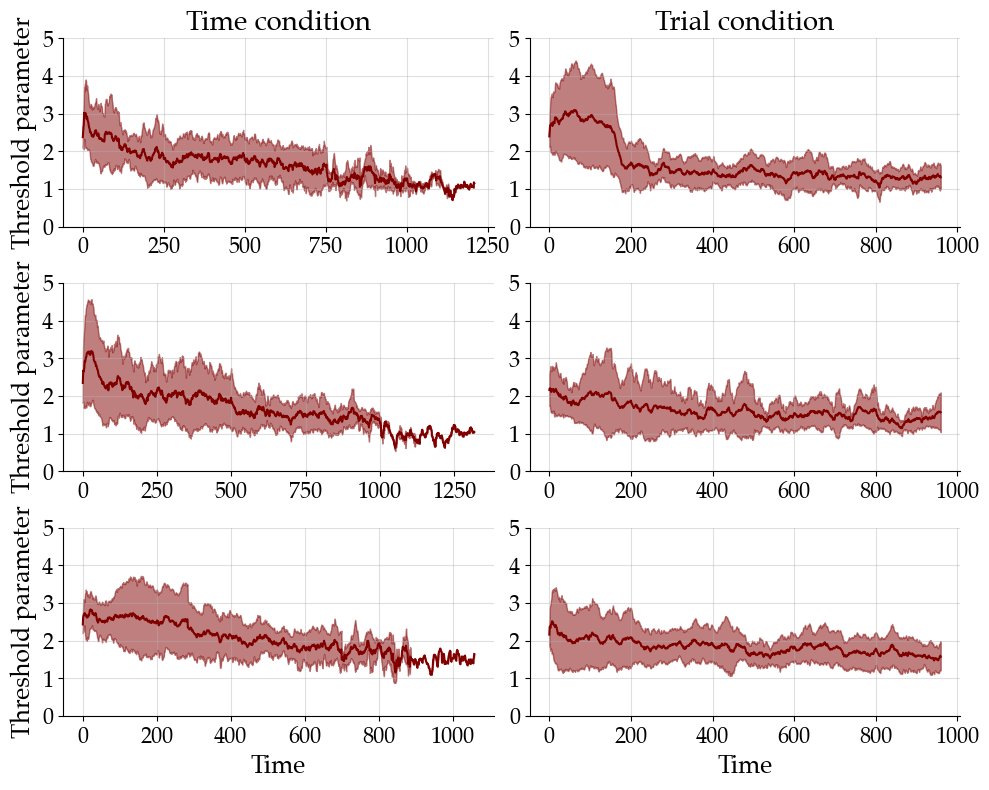

In [73]:
f, axarr = plt.subplots(3, 2, figsize=(10, 8))
for i, ax in enumerate(axarr.flat):
    ax.plot(
        np.arange(post_mean_summary.shape[1]), post_mean_summary[i, :, 1],
        color = "maroon"
    )
    ax.fill_between(
        np.arange(post_mean_summary.shape[1]),
        post_mean_summary[i, :, 1] - post_std_summary[i, :, 1],
        post_mean_summary[i, :, 1] + post_std_summary[i, :, 1],
        alpha = 0.5,
        color = "maroon"
    )

    # ax.axhline(1.0, linestyle='--', linewidth=2, color='black')
    ax.set_ylim([0, 4.5])
    if i < 2:
        ax.set_title(titles[i], fontsize=FONT_SIZE_1)

    if i > 3:
        ax.set_xlabel('Time', fontsize=FONT_SIZE_2)
    #     ax.set_ylabel("Parameter value", fontsize=18)
    if i == 0 or i == 2 or i == 4:
        ax.set_ylabel('Threshold parameter', fontsize=FONT_SIZE_2)

    # ax.set_title(PARAM_LABELS[i] + ' ({})'.format(PARAM_NAMES[i]), fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    ax.grid(alpha=0.4)
    ax.set_yticks([0, 1, 2, 3, 4, 5])
    ax.set_yticks([1, 200, 400, 600, 4, 5])
    
sns.despine()
f.tight_layout()

plt.savefig('../plots/optimal_policy_result.png', dpi=300)